# Udacity Self-Driving Car Nanodegree
## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline
print('done')

done


### 1. Camera Calibration and Distortion Correction

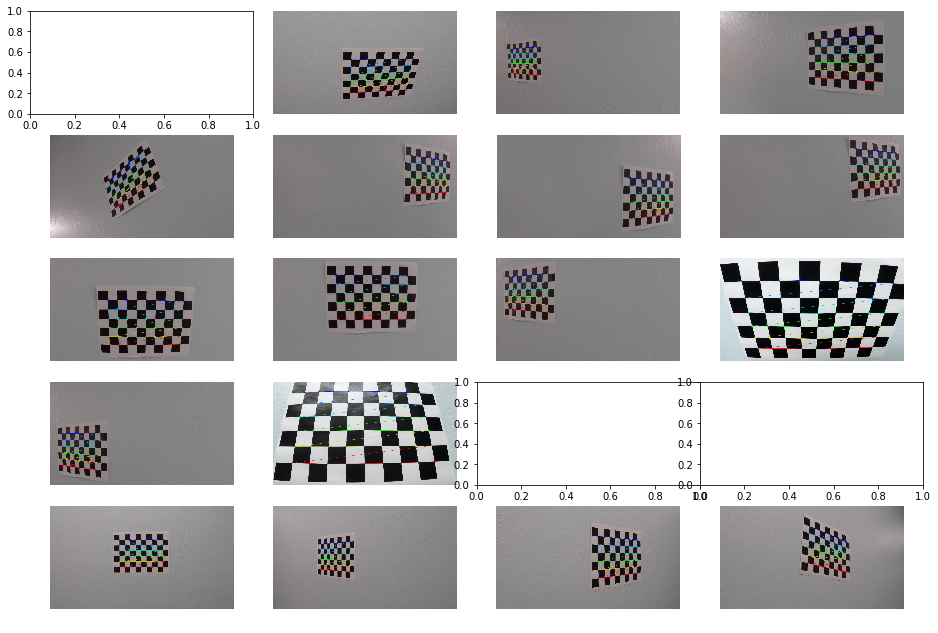

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
#creating 6x9 pts in an array
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        axs[idx].axis('off')
        axs[idx].imshow(img)



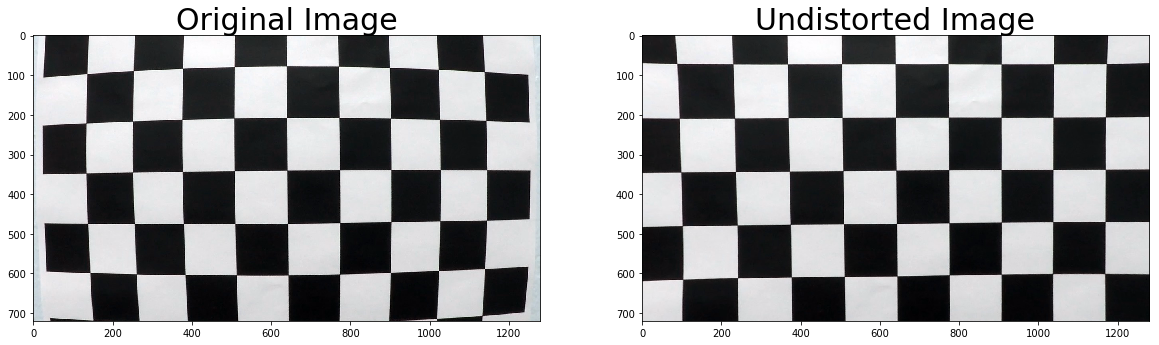

In [3]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

#### Test Image

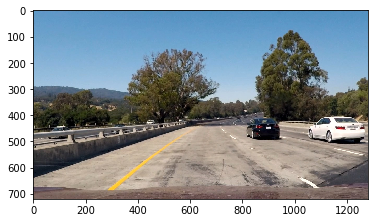

In [4]:
testimg = cv2.imread('./test_images/test1.jpg')
#convert the read image to RGB color space
testimg = cv2.cvtColor(testimg, cv2.COLOR_BGR2RGB)
plt.imshow(testimg)

### 2. Distortion Correction

In [5]:
def undistort(image):
    undistorted_img = cv2.undistort(image, mtx, dist, None, mtx)
    return undistorted_img
    

#### Undistort the test_img

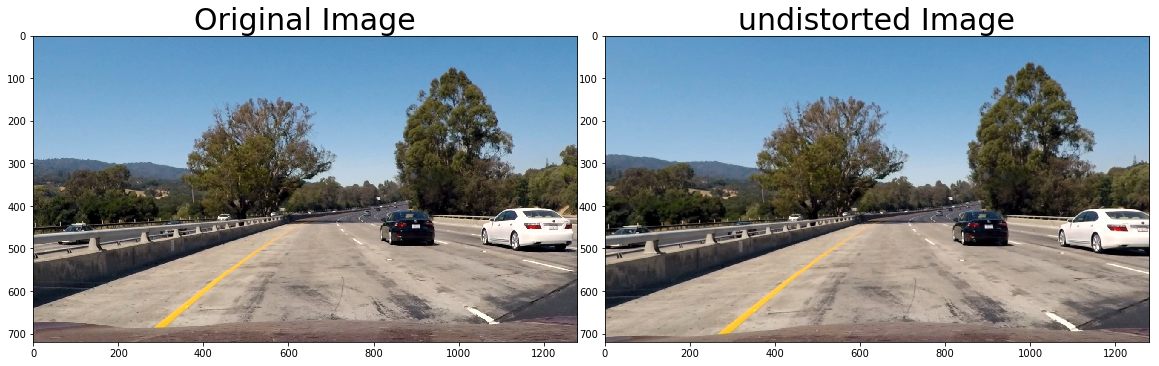

In [6]:
testimg_undistort = undistort(testimg)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(testimg)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(testimg_undistort)
ax2.set_title('undistorted Image', fontsize=30)

### 3. Perspective Transform

In [7]:
def warp_img(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a bird's eye view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

#### Apply Perspective Transform on the test_img

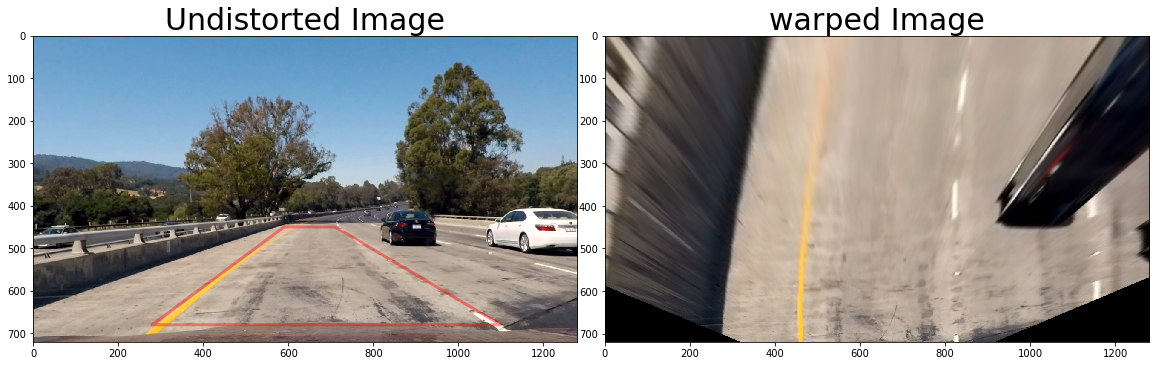

In [8]:
h,w = testimg_undistort.shape[:2]

# define source and destination points for transform
src = np.float32([(590,450),
                  (710,450), 
                  (280,680), 
                  (1100,680)])

dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

testimg_warped, M, Minv = warp_img(testimg_undistort, src, dst)

# Visualize warp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)

ax1.imshow(testimg_undistort)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='r', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)

ax2.imshow(testimg_warped)
ax2.set_title('warped Image', fontsize=30)


### 4. Gradients and Color Thresholding

#### Absolute Sobel Threshold

In [9]:
def abs_sobel_thresh(img, sobel_kernel=3, abs_thresh_min=0, abs_thresh_max=255, orient='x'):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    if (orient == 'x'):
        abs_sobel = np.abs(sobelx)
    else:
        abs_sobel = np.abs(sobely)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    
    scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
            
    grad_binary = np.zeros_like(scaled_sobel)
    
    grad_binary[(scaled_sobel >= abs_thresh_min) & (scaled_sobel <= abs_thresh_max)] = 1

    return grad_binary

#### Sobel Magnitude Threshold

In [10]:
def mag_sobel_thresh(image, sobel_kernel=3, mag_thresh_min=0, mag_thresh_max=255 ):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    
    sobel_mag = np.sqrt(np.square(abs_sobelx) + np.square(abs_sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_mag / np.max(sobel_mag))
    # 5) Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaled_sobel)
    
    sbinary[(scaled_sobel >= mag_thresh_min) & (scaled_sobel <= mag_thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return sbinary


#### Sobel Direction Threshold

In [11]:
def dir_sobel_thresh(image, sobel_kernel=3, dir_thresh_min=0, dir_thresh_max=255):
    # Calculate gradient direction
    # Apply threshold
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(grad_dir)
    
    dir_binary[(grad_dir >= dir_thresh_min)&(grad_dir <= dir_thresh_max)]=1
    # 6) Return this mask as your binary_output image
    return dir_binary

#### Combined (Absolute + Magnitude + Direction)

<function __main__.update>

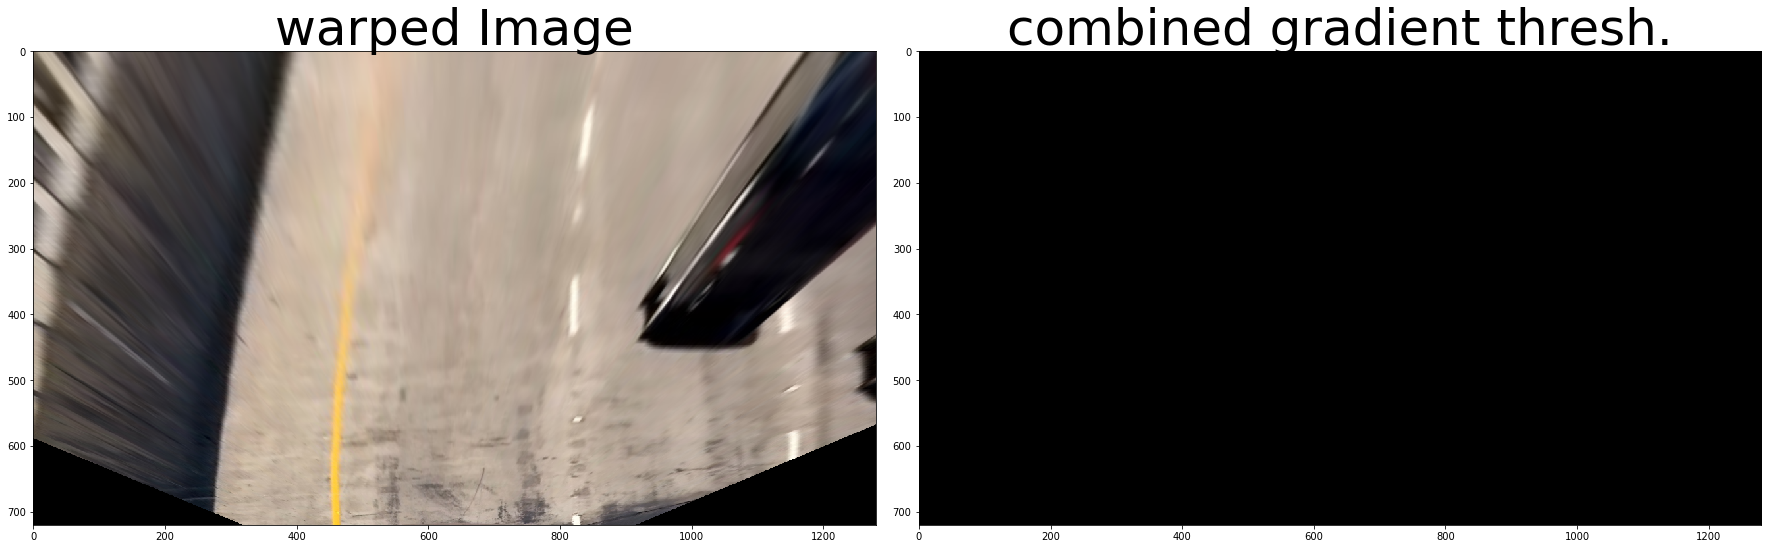

In [12]:
def combined_grad(image, sobel_kernel=3, abs_thresh=(30,100), mag_thresh = (10,100), dir_thresh = (0,0.5)):
    gradx = abs_sobel_thresh(image, sobel_kernel, abs_thresh[0] ,abs_thresh[1], orient='x')
    grady = abs_sobel_thresh(image, sobel_kernel, abs_thresh[0] ,abs_thresh[1], orient='y')
    mag_binary = mag_sobel_thresh(image, sobel_kernel, mag_thresh[0], mag_thresh[1])
    dir_binary = dir_sobel_thresh(image, sobel_kernel, dir_thresh[0], dir_thresh[1])


    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined
    
# Apply each of the thresholding functions
def update(sobel_kernel, abs_thresh_min, abs_thresh_max, mag_thresh_min, mag_thresh_max, dir_thresh_min, dir_thresh_max):
    
    combined = combined_grad(testimg_warped, sobel_kernel, 
                             abs_thresh = (abs_thresh_min, abs_thresh_max), 
                             mag_thresh = (mag_thresh_min, mag_thresh_max), 
                             dir_thresh = (dir_thresh_min, dir_thresh_max))

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(testimg_warped)
    ax1.set_title('warped Image', fontsize=50)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('combined gradient thresh.', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


interact(update, sobel_kernel=(1,31,2), 
                 abs_thresh_min=(0,255),
                 abs_thresh_max=(0,255),
                 mag_thresh_min=(0,255),
                 mag_thresh_max=(0,255),
                 dir_thresh_min=(0,np.pi/2,0.01),
                 dir_thresh_max=(0,np.pi/2,0.01))

#### Color Thresholding

#### HLS Visualization

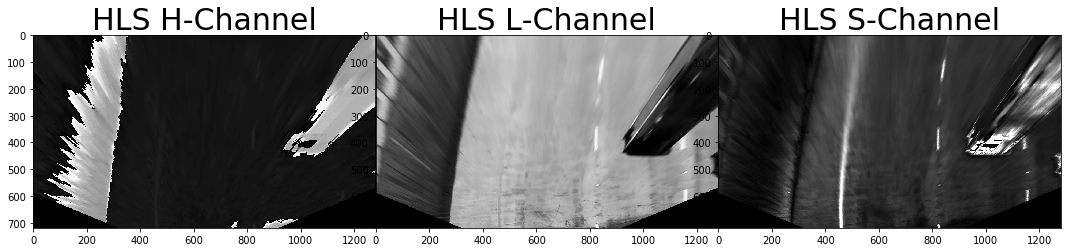

In [13]:
testimg_warped_hls = cv2.cvtColor(testimg_warped, cv2.COLOR_RGB2HLS)
testimg_warped_h = testimg_warped_hls[:,:,0]
testimg_warped_l = testimg_warped_hls[:,:,1]
testimg_warped_s = testimg_warped_hls[:,:,2]
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 12))
f.tight_layout()
ax1.imshow(testimg_warped_h, cmap='gray')
ax1.set_title('HLS H-Channel', fontsize=30)
ax2.imshow(testimg_warped_l, cmap='gray')
ax2.set_title('HLS L-Channel', fontsize=30)
ax3.imshow(testimg_warped_s, cmap='gray')
ax3.set_title('HLS S-Channel', fontsize=30)
plt.subplots_adjust(hspace = .2, wspace=.001)

#### HSV Visualization

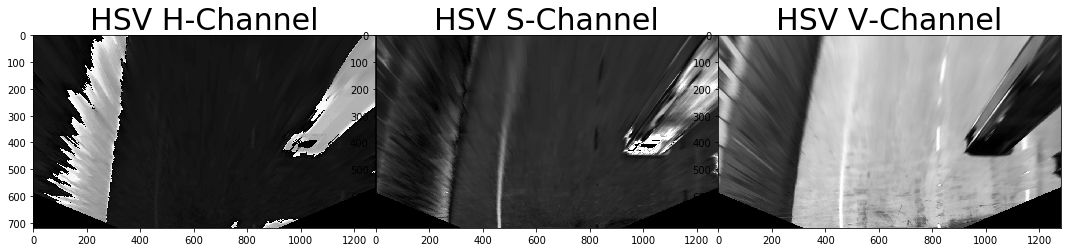

In [14]:
testimg_warped_hsv = cv2.cvtColor(testimg_warped, cv2.COLOR_RGB2HSV)
testimg_warped_h = testimg_warped_hsv[:,:,0]
testimg_warped_s = testimg_warped_hsv[:,:,1]
testimg_warped_v = testimg_warped_hsv[:,:,2]
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 12))
f.tight_layout()
ax1.imshow(testimg_warped_h, cmap='gray')
ax1.set_title('HSV H-Channel', fontsize=30)
ax2.imshow(testimg_warped_s, cmap='gray')
ax2.set_title('HSV S-Channel', fontsize=30)
ax3.imshow(testimg_warped_v, cmap='gray')
ax3.set_title('HSV V-Channel', fontsize=30)
plt.subplots_adjust(hspace = .2, wspace=.001)

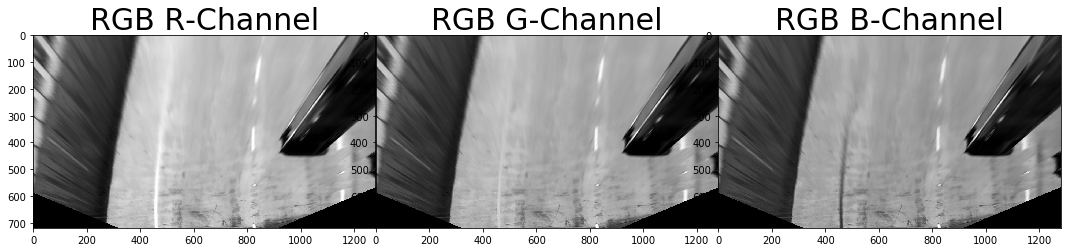

In [15]:
testimg_warped_r = testimg_warped[:,:,0]
testimg_warped_g = testimg_warped[:,:,1]
testimg_warped_b = testimg_warped[:,:,2]
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 12))
f.tight_layout()
ax1.imshow(testimg_warped_r, cmap='gray')
ax1.set_title('RGB R-Channel', fontsize=30)
ax2.imshow(testimg_warped_g, cmap='gray')
ax2.set_title('RGB G-Channel', fontsize=30)
ax3.imshow(testimg_warped_b, cmap='gray')
ax3.set_title('RGB B-Channel', fontsize=30)
plt.subplots_adjust(hspace = .2, wspace=.001)

#### HLS S-Channel

In [16]:
# Define a function that thresholds the L-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_sthresh(img, thresh=(80, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_s = hls[:,:,2]
    hls_s = hls_s*(255/np.max(hls_s))
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hls_s)
    binary_output[(hls_s > thresh[0]) & (hls_s <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

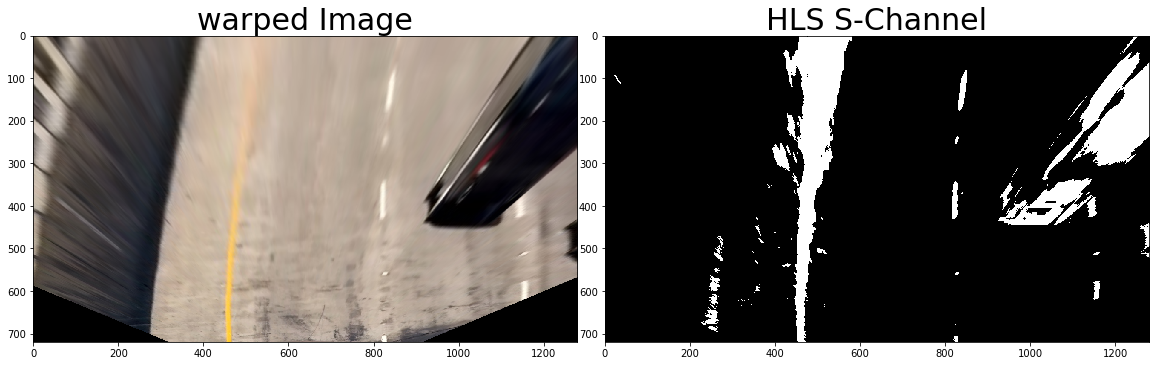

In [17]:
def update(min_thresh, max_thresh):
    testimg_sthresh = hls_sthresh(testimg_warped, (min_thresh, max_thresh))
    # Visualize hls s-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(testimg_warped)
    ax1.set_title('warped Image', fontsize=30)
    ax2.imshow(testimg_sthresh, cmap='gray')
    ax2.set_title('HLS S-Channel', fontsize=30)

interact(update,
         min_thresh=(0,255), 
         max_thresh=(0,255))

print('...')

#### RGB R-Channel

In [18]:
# Define a function that thresholds the L-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def rgb_rthresh(img, thresh=(230, 255)):
    rgb_r = img[:,:,0]
    rgb_r = rgb_r*(255/np.max(rgb_r))
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(rgb_r)
    binary_output[(rgb_r > thresh[0]) & (rgb_r <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

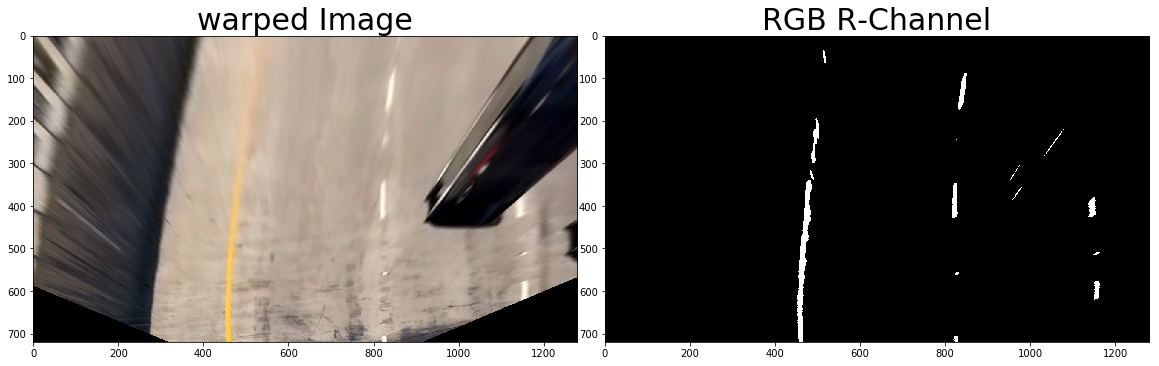

In [19]:
def update(min_thresh, max_thresh):
    testimg_rthresh = rgb_rthresh(testimg_warped, (min_thresh, max_thresh))
    # Visualize rgb r-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(testimg_warped)
    ax1.set_title('warped Image', fontsize=30)
    ax2.imshow(testimg_rthresh, cmap='gray')
    ax2.set_title('RGB R-Channel', fontsize=30)

interact(update,
         min_thresh=(0,255), 
         max_thresh=(0,255))

print('...')

#### Pipeline

In [20]:
# Define the complete image processing pipeline, reads raw image and returns binary image with lane lines
def pipeline(img):
    # Undistort
    img_undistort = undistort(img)
    
    # Perspective Transform
    img_warped, M, Minv = warp_img(img_undistort, src, dst)

    # combined gradient(Absolute + Magnitude + Direction) (using default parameters)
    img_combined_grad = combined_grad(img_warped)

    # HLS S-channel Threshold (using default parameters)
    img_sthresh = hls_sthresh(img_warped)

    # RGB R-channel Threshold (using default parameters)
    img_rthresh = rgb_rthresh(img_warped)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_sthresh)
    combined[((img_sthresh == 1) & (img_combined_grad == 1)) | (img_rthresh == 1)] = 1
    
    return combined, Minv
    

#### Test Pipeling on All test images

...


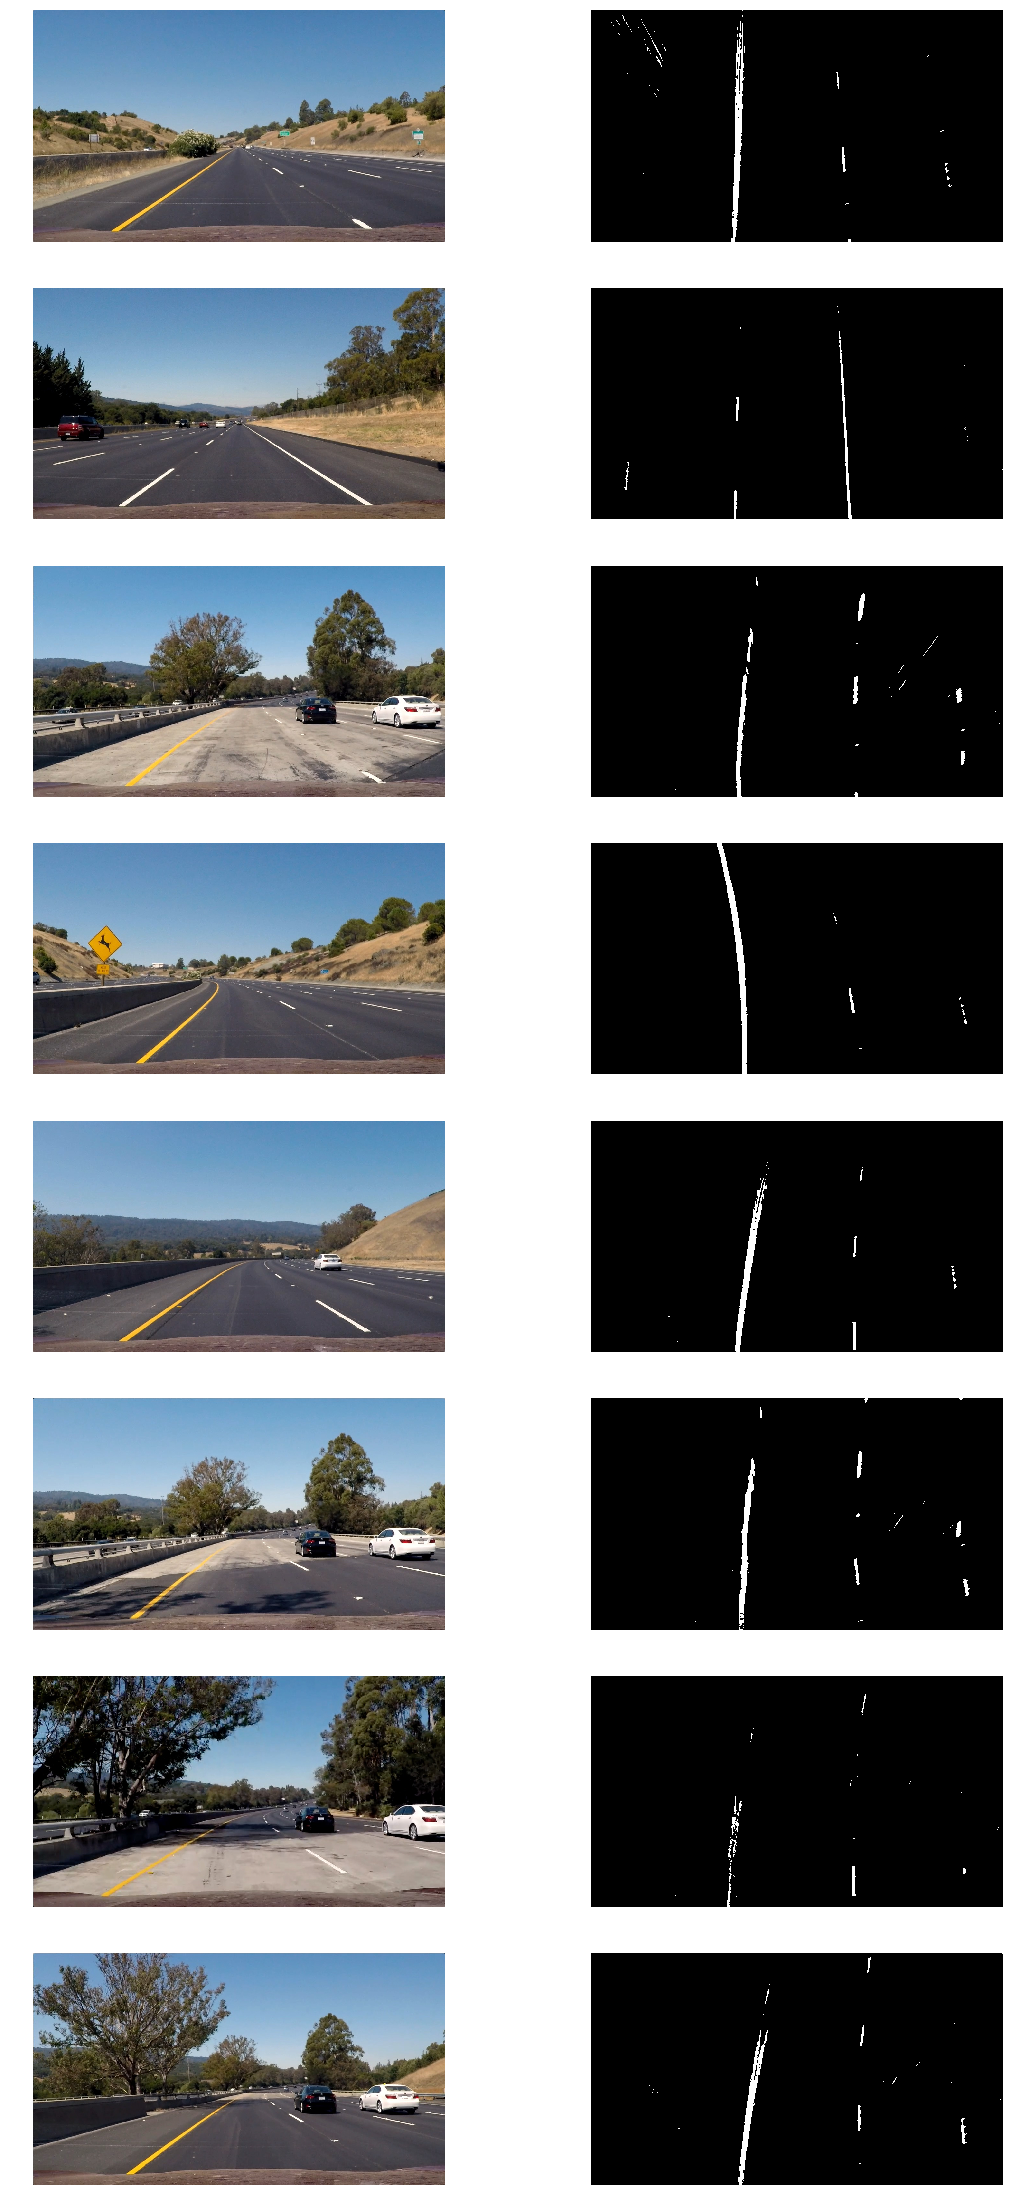

In [21]:
# Make a list of test images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(20, 40))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, Minv = pipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

print('...')

### 5. Sliding Window

In [22]:
#Define method that fits polynomials to lane lines by applying sliding window method
def sliding_window_line_fit(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

#     quarter_point = np.int(midpoint//2)
    
#     leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
#     rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    window_data = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        window_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, window_data, histogram

#### Sliding Window and Line fitting Visualization

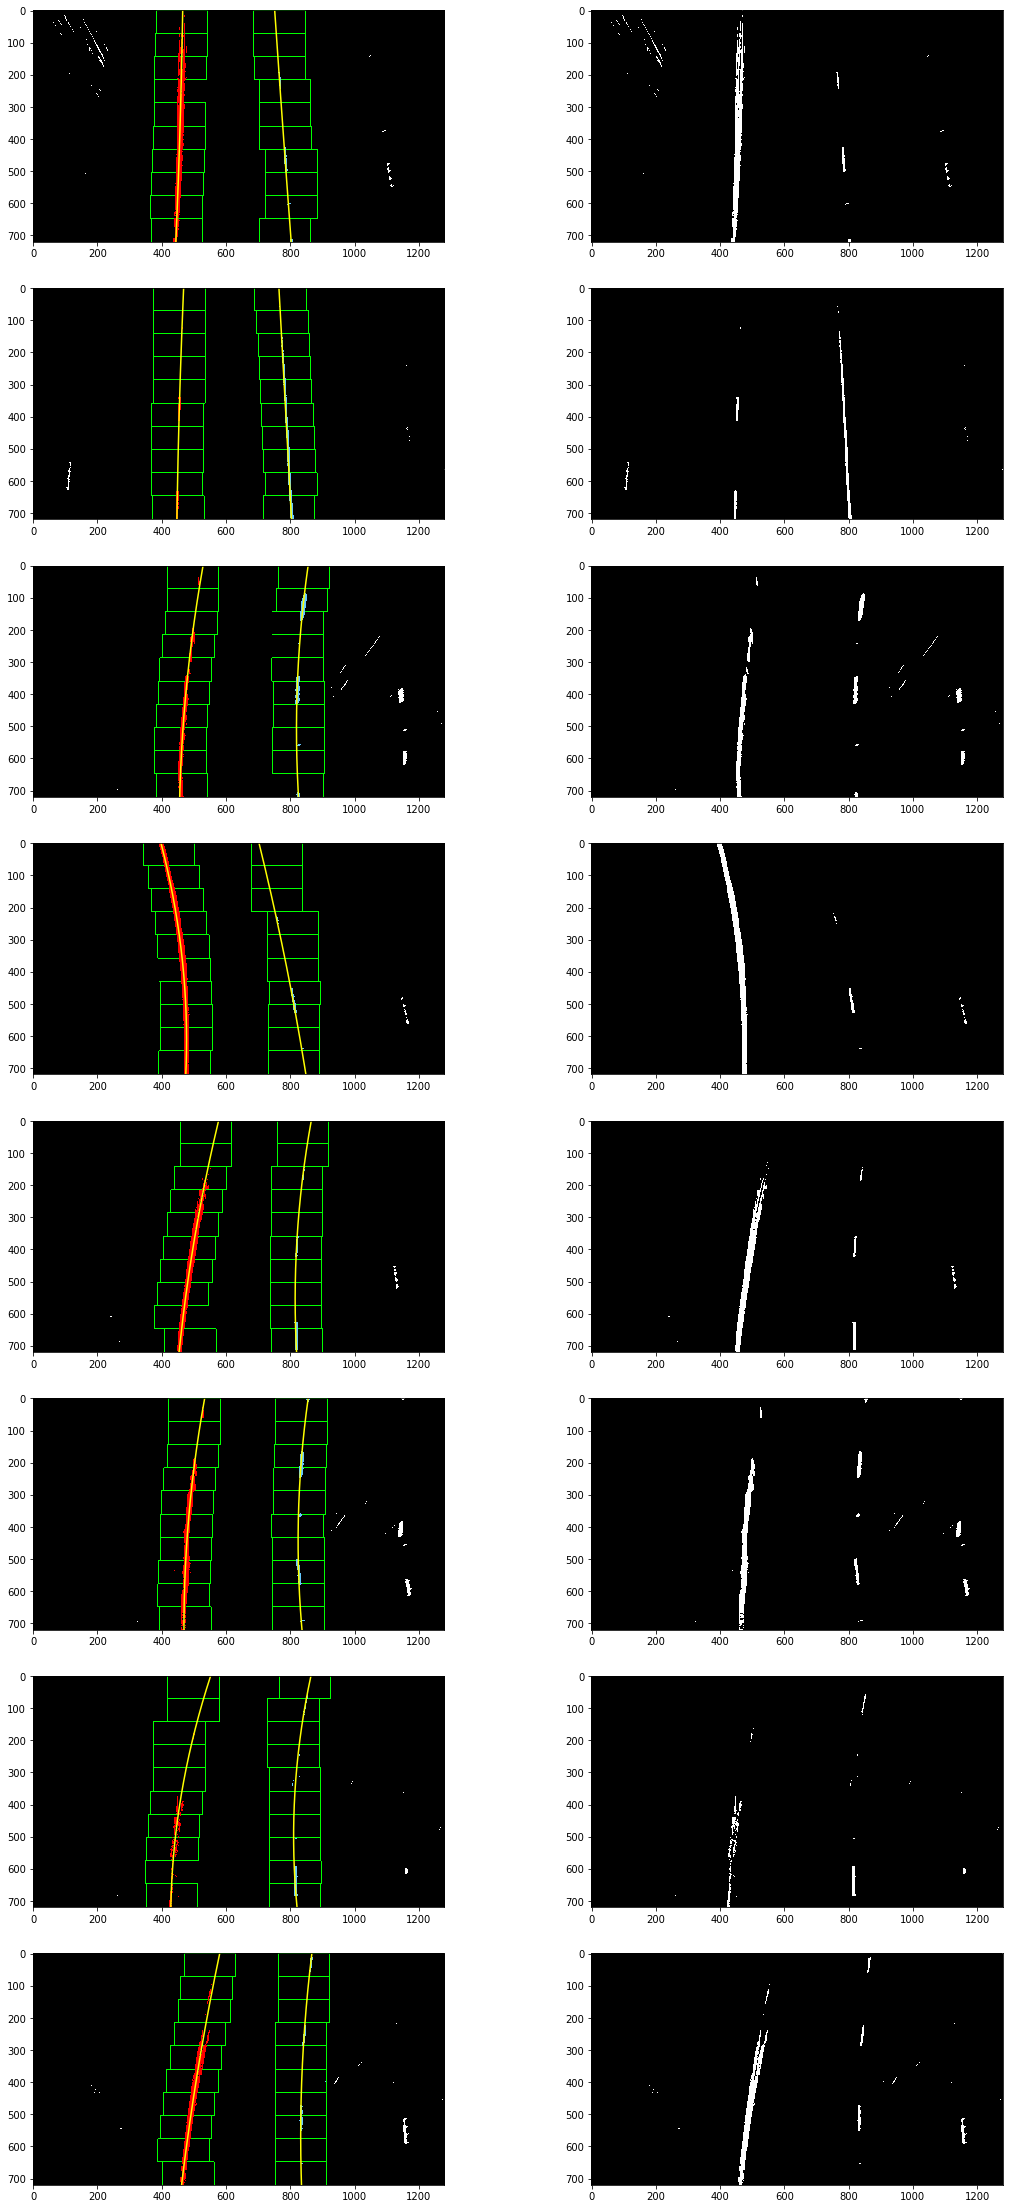

In [23]:
# visualize the result on test image

images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(20, 40))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    testimg = cv2.imread(image)
    testimg = cv2.cvtColor(testimg, cv2.COLOR_BGR2RGB)
    testimg_binary, Minv = pipeline(testimg)
    
    left_fit, right_fit, left_lane_inds, right_lane_inds, windows_data, histogram = sliding_window_line_fit(testimg_binary)

    # Generate x and y values for plotting
    ploty = np.linspace(0, testimg_binary.shape[0]-1, testimg_binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an output image to draw on and  visualize the result
    out_img = np.uint8(np.dstack((testimg_binary, testimg_binary, testimg_binary))*255)

    for window in windows_data:
    # Draw the windows on the visualization image
        cv2.rectangle(out_img,(window[2],window[0]),(window[3],window[1]),(0,255,0), 2) 
        cv2.rectangle(out_img,(window[4],window[0]),(window[5],window[1]),(0,255,0), 2) 

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = testimg_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]

#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#     f.subplots_adjust(hspace = .2, wspace=.05)

#     ax1.imshow(out_img)
#     ax1.plot(left_fitx, ploty, color='yellow')
#     ax1.plot(right_fitx, ploty, color='yellow')

#     ax2.imshow(testimg_binary, cmap='gray')

    
    
    
    axs[i].imshow(out_img)
    axs[i].plot(left_fitx, ploty, color='yellow')
    axs[i].plot(right_fitx, ploty, color='yellow')
#     axs[i].axis('off')
    i += 1
    axs[i].imshow(testimg_binary, cmap='gray')
#     axs[i].axis('off')
    i += 1
    
    
    


...


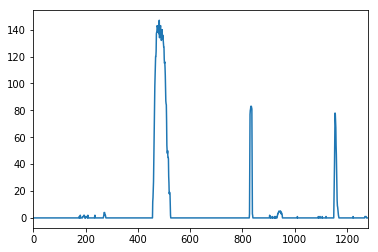

In [24]:
# Print histogram from sliding window polyfit for test image
plt.plot(histogram)
plt.xlim(0, 1280)
print('...')

#### Line fitting from a previous frame fit data

In [25]:
# Define method to fit polynomial to binary image based upon a previous fit
def line_fit_from_prev_frame(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

#### Line fitting from a previous frame fit Visualization

(720, 0)

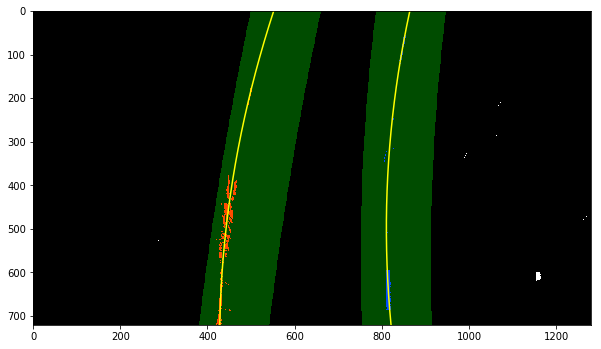

In [26]:
# visualize the result on test image
testimg1 = cv2.imread('./test_images/test4.jpg')
testimg1 = cv2.cvtColor(testimg1, cv2.COLOR_BGR2RGB)
testimg1_binary, Minv1 = pipeline(testimg1)   

testimg2 = cv2.imread('./test_images/test5.jpg')
testimg2 = cv2.cvtColor(testimg2, cv2.COLOR_BGR2RGB)
testimg2_binary, Minv2 = pipeline(testimg2)   
margin = 80

left_fit1, right_fit1, left_lane_inds1, right_lane_inds1, windows_data1, histogram1 = sliding_window_line_fit(testimg1_binary)

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = line_fit_from_prev_frame(testimg2_binary, left_fit1, right_fit1)

# Generate x and y values for plotting
ploty = np.linspace(0, testimg2_binary.shape[0]-1, testimg2_binary.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((testimg2_binary, testimg2_binary, testimg2_binary))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = testimg2_binary.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.figure(figsize=(10,18))
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### 6. Radius of Curvature Calculation

In [27]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

#### Radius of Curvature Calculation on Test Image

In [28]:
testimg = cv2.imread('./test_images/test5.jpg')
testimg = cv2.cvtColor(testimg, cv2.COLOR_BGR2RGB)
testimg_binary, Minv = pipeline(testimg)

left_fit, right_fit, left_lane_inds, right_lane_inds, windows_data, histogram = sliding_window_line_fit(testimg_binary)


rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(testimg_binary, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 222.293340952 m, 219.24099399 m
Distance from lane center for example: 0.149796694145 m


### 7. Warp detected lane on the original image with calculated data

### Lane Lines Drawing

In [29]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    
    return result

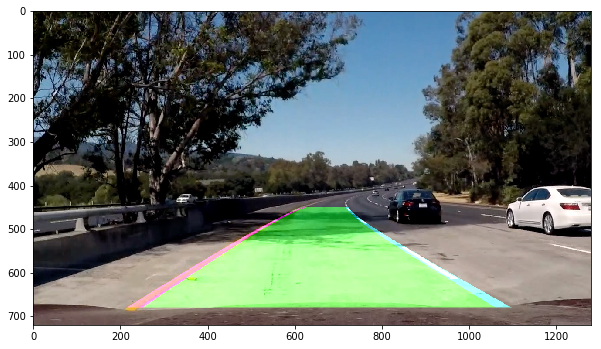

In [30]:
testimg_out = draw_lane(testimg, testimg_binary, left_fit, right_fit, Minv)
plt.figure(figsize=(10,18))
plt.imshow(testimg_out)

#### Draw Lane Data (Radius of Curvature, dist_to_center) on the test image

In [31]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

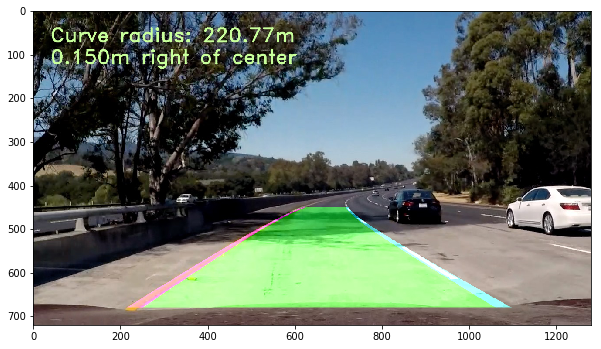

In [32]:
testimg_data_out = draw_data(testimg_out, (rad_l+rad_r)/2, d_center)
plt.figure(figsize=(10,18))
plt.imshow(testimg_data_out)

### 8. Output Visual Display

#### Class for Storing Data

In [33]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


#### Processing Pipeline

In [34]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, windows_data, histogram = sliding_window_line_fit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = line_fit_from_prev_frame(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    return img_out

#### Process Project Video

In [36]:
l_line = Line()
r_line = Line()
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip("project_video.mp4")
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████▉| 1260/1261 [06:48<00:00,  3.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 6min 49s
